In [14]:
# !rm -rf /content/PwPD

# **Installation**

In [16]:
!pip install audb

In [17]:
!pip install pydub

In [18]:
!pip install shap

In [19]:
!pip install opensmile

In [20]:
# !pip install alibi

In [21]:
import os
import time
import datetime
import errno
import random
import copy
import pickle
from tensorflow.keras.optimizers import Adam
import joblib
import collections
from datetime import timedelta, date
from collections import Counter
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import joblib
import audb
import audiofile
import opensmile

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, ParameterGrid
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, log_loss, confusion_matrix,
    classification_report, precision_recall_curve
)
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import imblearn

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import (
    Dense, Activation, LSTM, Bidirectional, RepeatVector, Dropout,
    TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
)
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

# Seaborn theme setup
sns.set_theme()

# Inline plotting for Jupyter Notebook
%matplotlib inline


# **Documentation**


Documentation opensmile : https://audeering.github.io/opensmile-python/install.html

Github : https://audeering.github.io/opensmile-python/install.html

Audiofile : https://audeering.github.io/audiofile/installation.html

# **LowLevelDescriptors**

In [ ]:
# file_path = "/content/HS/VA1ACNAGRER49F210320170920.wav"

# signal, sampling_rate = audiofile.read(file_path, always_2d=True)

# smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.ComParE_2016,
#     feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
# )
# features = smile.process_signal(signal, sampling_rate)

# # csv_file_path = '/content/extracted_features_VA1MGIACTHT49M210320170855.csv'
# # features.to_csv(csv_file_path, index=False)

# # print(f"Features saved to {csv_file_path}")
# features

In [ ]:
# def remove_silence_from_folder(input_folder, output_folder, silence_thresh=-40, min_silence_len=500):
#     """
#     Removes silence from all WAV files in a folder and saves the processed files
#     in a new folder with the same name but inside the 'processed_audio' directory.

#     :param input_folder: Path to the folder containing .wav files
#     :param silence_thresh: Silence threshold in dBFS (default -40 dB)
#     :param min_silence_len: Minimum silence duration in milliseconds to be removed (default 500ms)
#     """

#     os.makedirs(output_folder, exist_ok=True)
#     audio_files = [f for f in os.listdir(input_folder) if f.endswith(".wav")]

#     for file in audio_files:
#         input_file = os.path.join(input_folder, file)
#         output_file = os.path.join(output_folder, file)

#         audio = AudioSegment.from_wav(input_file)
#         nonsilent_chunks = detect_nonsilent(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)

#         processed_audio = AudioSegment.empty()
#         for start, end in nonsilent_chunks:
#             processed_audio += audio[start:end]

#         processed_audio.export(output_file, format="wav")
#         print(f"Processed audio saved as {output_file}")

#     print(f"\nAll processed files saved in: {output_folder}")

# input_folder = "/content/audio_files"
# output_folder = "/content/processed_audio"
# remove_silence_from_folder(input_folder, output_folder, silence_thresh=-40, min_silence_len=500)

In [22]:
# Hyper Paramaters

#LSTM
univariate = False
n_steps_in = 10
n_seq = 2
n_steps_out = 2
n_features_in = 65
n_features_out = 2
hidden_layers = 50
Epochs = 1000
No_exp = 1
batch_size = 128

print(f"Univariate: {univariate}")
print(f"Number of Input Time Steps: {n_steps_in}")
print(f"Number of Input Sequences: {n_seq}")
print(f"Number of Output Time Steps: {n_steps_out}")
print(f"Number of Input Features: {n_features_in}")
print(f"Number of Output Features: {n_features_out}")
print(f"Number of Hidden Layers: {hidden_layers}")
print(f"Epochs: {Epochs}")
print(f"Number of Experiments: {No_exp}")
print(f"Batch size: {batch_size}")

#Optimiser
lr_adam = 0.0001

#Loss Function
label_smoothing = 0.05

#Activation
negative_slope = 0.01

#Optimizer and Loss Function
optimizer = Adam(learning_rate = lr_adam)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing)
activation_lstm = tf.keras.layers.LeakyReLU(negative_slope = negative_slope)
# activation_lstm = tf.keras.activations.swish
# activation_lstm = 'relu'
activation_dense = 'softmax'

Univariate: False
Number of Input Time Steps: 10
Number of Input Sequences: 2
Number of Output Time Steps: 2
Number of Input Features: 65
Number of Output Features: 2
Number of Hidden Layers: 50
Epochs: 1000
Number of Experiments: 1
Batch size: 128


In [ ]:
def process_audio_folder(folder_path, n, label):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    audio_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".wav")])

    X_list = []
    Y_list = []

    for file in audio_files:
        # print("currently on file: " + str(file))
        file_path = os.path.join(folder_path, file)

        signal, sampling_rate = audiofile.read(file_path, always_2d=True)

        features = smile.process_signal(signal, sampling_rate).to_numpy()

        # print(features.shape)
        # print(sampling_rate)

        segments = [features[i:i+n] for i in range(0, len(features) - n + 1, n)]
        segments = [segment for segment in segments if segment.shape == (n, features.shape[1])]

        if segments:
            X_list.extend(segments)
            Y_list.extend([label] * len(segments))

    # Convert to NumPy arrays
    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.int32)

    # Ensure labels are properly one-hot encoded
    Y = to_categorical(Y, num_classes=2)

    return X, Y

In [ ]:
folder_path = "/content/HS"
n = n_steps_in
label = 0
X1, Y1= process_audio_folder(folder_path, n, label)
print(X1.shape)
print(Y1.shape)

(3029, 10, 65)
(3029, 2)


In [ ]:
folder_path = "/content/PwPD"
n = n_steps_in
label = 1
X2, Y2= process_audio_folder(folder_path, n, label)
print(X2.shape)
print(Y2.shape)

(5079, 10, 65)
(5079, 2)


In [ ]:
def balance_classes(X1, Y1, X2, Y2):
    min_samples = min(len(X1), len(X2))

    indices1 = np.random.choice(len(X1), min_samples, replace=False)
    indices2 = np.random.choice(len(X2), min_samples, replace=False)

    X1_balanced, Y1_balanced = X1[indices1], Y1[indices1]
    X2_balanced, Y2_balanced = X2[indices2], Y2[indices2]

    return X1_balanced, Y1_balanced, X2_balanced, Y2_balanced

X1, Y1, X2, Y2 = balance_classes(X1, Y1, X2, Y2)
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(3029, 10, 65)
(3029, 2)
(3029, 10, 65)
(3029, 2)


In [ ]:
X = np.concatenate((X1,X2), axis = 0)
Y = np.concatenate((Y1,Y2), axis = 0)

In [ ]:
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_normalized = X_scaled.reshape(X.shape)
print(X_normalized.shape)

(6058, 10, 65)


In [ ]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
X = X_normalized

In [ ]:
idx = np.random.permutation(len(X))

x_shuffled = []
y_shuffled = []

for i in idx:
    x_shuffled.append(X[i])
    y_shuffled.append(Y[i])

x_a = np.array(x_shuffled)
print(x_a.shape)
X = x_shuffled
Y = y_shuffled

(6058, 10, 65)


In [ ]:
print(Y)

[array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.

In [ ]:
train_X, test_X, Y_hot_encoded_train, Y_hot_encoded_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(Y_hot_encoded_test)

[array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.

In [ ]:
idx = np.random.permutation(len(train_X))

x_shuffled = []
y_shuffled = []

for i in idx:

    x_shuffled.append(train_X[i])
    y_shuffled.append(Y_hot_encoded_train[i])

x_a = np.array(x_shuffled)
print(x_a.shape)

train_X = x_shuffled
Y_hot_encoded_train = y_shuffled

(4846, 10, 65)


In [ ]:
idx = np.random.permutation(len(test_X))

x_shuffled = []
y_shuffled = []

for i in idx:

    x_shuffled.append(test_X[i])
    y_shuffled.append(Y_hot_encoded_test[i])

x_a = np.array(x_shuffled)
print(x_a.shape)

test_X = x_shuffled
Y_hot_encoded_test = y_shuffled

(1212, 10, 65)


In [ ]:
Y_hot_encoded_test[12]

array([0., 1.])

# **LSTM**

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# def focal_loss(alpha=0.25, gamma=2.0):
#     def loss(y_true, y_pred):
#         epsilon = K.epsilon()  # Small value to avoid log(0)
#         y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Clipping to avoid instability

#         # Compute binary cross-entropy loss
#         bce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)

#         # Compute the focal weight
#         focal_weight = y_true * (1 - y_pred) ** gamma + (1 - y_true) * y_pred ** gamma

#         # Apply the alpha balancing factor
#         focal_weight *= alpha * y_true + (1 - alpha) * (1 - y_true)

#         # Compute the final focal loss
#         focal_loss = -focal_weight * bce
#         return K.mean(focal_loss)

#     return loss

In [ ]:
def vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out, hidden_layers):
  model = Sequential()
  model.add(LSTM(hidden_layers, activation= activation_lstm, input_shape=(n_steps_in, n_features_in), kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.3))
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

def bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out, hidden_layers):
  model = Sequential()
  model.add(Bidirectional(LSTM(hidden_layers, activation= None, input_shape=(n_steps_in, n_features_in))))
  model.add(Dropout(0.3))
  model.add(tf.keras.layers.LeakyReLU(negative_slope=0.01))    #added to incorporate leaky relu
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

# categorical crossentropy, focal loss
def cnn_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq, hidden_layers):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation=activation_lstm), input_shape=(n_seq, int(n_steps_in/n_seq), n_features_in)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(hidden_layers, activation= activation_lstm))
  model.add(Dropout(0.3))
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

def conv_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation= activation_lstm, input_shape=(n_seq, 1, int(n_steps_in/n_seq), n_features_in)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

In [ ]:
def MODEL_LSTM(model_name, method, univariate, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, hidden_layers):
    train_f1, test_f1 = np.zeros(Num_Exp), np.zeros(Num_Exp)
    roc_auc_train_values, roc_auc_test_values = np.zeros(Num_Exp), np.zeros(Num_Exp)

    # Model Selection using Dictionary Mapping
    if model_name == 'vanilla':
        model = vanilla(n_steps_in, n_steps_out, n_features_in, n_features_out, hidden_layers)
    elif model_name == 'bidirectional':
        model = bidirectional(n_steps_in, n_steps_out, n_features_in, n_features_out, hidden_layers)
    elif model_name == 'cnn-lstm':
        model = cnn_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq, hidden_layers)
    elif model_name == 'conv-lstm':
        model = conv_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq)

    model.summary()

    act_test = y_test.argmax(axis=1)
    act_train = y_train.argmax(axis=1)

    start_time = time.time()
    Best_f1, Best_Predict_Test = 0, None

    all_report_train, all_report_test = {}, {}
    train_loss_per_epoch, test_loss_per_epoch = [], []

    for run in range(Num_Exp):
        print(f"Experiment {run + 1}/{Num_Exp} in progress")

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        history = model.fit(x_train, y_train, epochs=Epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(x_test, y_test))

        train_loss_per_epoch.append(history.history['loss'])
        test_loss_per_epoch.append(history.history['val_loss'])

        y_predicttrain, y_predicttest = model.predict(x_train), model.predict(x_test)
        pred_train, pred_test = y_predicttrain.argmax(axis=1), y_predicttest.argmax(axis=1)

        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        all_report_train[run], all_report_test[run] = report_train, report_test
        train_f1[run], test_f1[run] = report_train['1']['f1-score'], report_test['1']['f1-score']
        roc_auc_train_values[run] = roc_auc_score(y_train[:, 1], y_predicttrain[:, 1])
        roc_auc_test_values[run] = roc_auc_score(y_test[:, 1], y_predicttest[:, 1])

        print(f"Train Acc: {report_train['accuracy']:.4f}, Test Acc: {report_test['accuracy']:.4f}")
        print(f"Train Recall: {report_train['1']['recall']:.4f}, Test Recall: {report_test['1']['recall']:.4f}")
        print(f"Train Precision: {report_train['1']['precision']:.4f}, Test Precision: {report_test['1']['precision']:.4f}")
        print(f"Train F1: {train_f1[run]:.4f}, Test F1: {test_f1[run]:.4f}")
        print(f"Train ROC AUC: {roc_auc_train_values[run]:.4f}, Test ROC AUC: {roc_auc_test_values[run]:.4f}")

        if test_f1[run] > Best_f1:
            Best_f1, Best_Predict_Test = test_f1[run], y_predicttest

    model.save(f"model_{model_name}_{method}.h5")
    elapsed_time = time.time() - start_time

    print(f"\nTotal Time for {Num_Exp} Experiments: {elapsed_time:.2f} sec")
    print(f"Mean Test F1: {np.mean(test_f1):.4f}, Mean Test ROC AUC: {np.mean(roc_auc_test_values):.4f}")

    fpr, tpr, _ = roc_curve(y_test[:, 1], Best_Predict_Test[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {np.mean(roc_auc_test_values):.4f}', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend()
    plt.show()

    train_loss_mean, test_loss_mean = np.mean(train_loss_per_epoch, axis=0), np.mean(test_loss_per_epoch, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Epochs+1), train_loss_mean, label='Train Loss', color='blue')
    plt.plot(range(1, Epochs+1), test_loss_mean, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Test Loss ({model_name})')
    plt.legend()
    plt.show()

    return model, np.mean(train_f1), np.mean(test_f1), np.std(train_f1), np.std(test_f1), Best_Predict_Test, y_predicttrain, y_predicttest, all_report_train, all_report_test, train_loss_mean, test_loss_mean, roc_auc_train_values, roc_auc_test_values


In [ ]:
#models = ['vanilla', 'bidirectional', 'cnn-lstm', 'conv-lstm']
models = ['vanilla']
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()
train_loss_all = dict()
test_loss_all = dict()

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

---------------------------------------------------------
No of steps out: 1
For vanilla:
(4846, 10, 65) (1212, 10, 65) (4846, 2) (1212, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          23,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,302 (91.02 KB)

 Trainable params: 23,302 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Train Acc: 1.0000, Test Acc: 0.9728
Train Recall: 1.0000, Test Recall: 0.9732
Train Precision: 1.0000, Test Precision: 0.9748
Train F1: 1.0000, Test F1: 0.9740
Train ROC AUC: 1.0000, Test ROC AUC: 0.9880

Total Time for 1 Experiments: 8608.21 sec
Mean Test F1: 0.9740, Mean Test ROC AUC: 0.9880


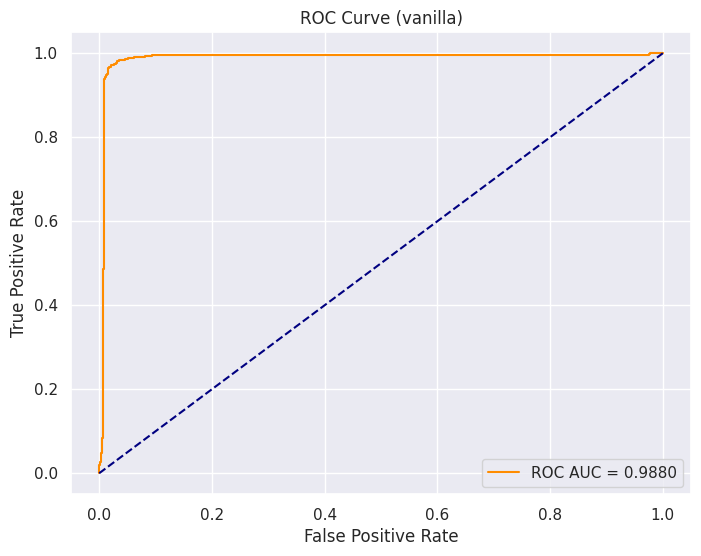

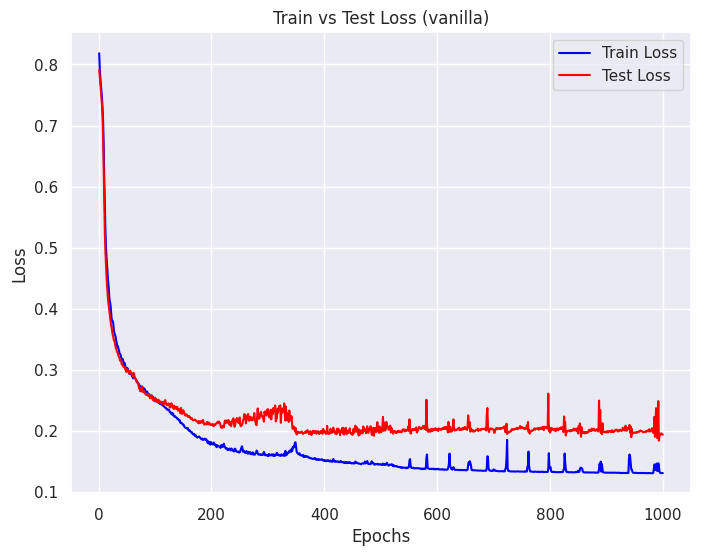

In [ ]:
for j in range(No_exp):
    predictions_train_per_step = dict()
    actual_train_per_step = dict()
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    test_acc_per_step = dict()
    test_stddev_per_step = dict()
    train_loss_per_step = dict()
    test_loss_per_step = dict()

    n_steps_out = j + 1
    print('---------------------------------------------------------')
    print('No of steps out:', n_steps_out)

    for i in models:
        print("For " + i + ":")

        # Reshaping input data based on the model type
        if i in ['vanilla', 'bidirectional']:
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

        elif i == 'cnn-lstm':
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))

        elif i == 'conv-lstm':
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))

        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

        # Train the model and return loss values
        model, train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test, train_loss, test_loss, roc_auc_train_values, roc_auc_test_values = MODEL_LSTM(
            i, 'original', univariate, x_train, x_test, y_train, y_test, 1, n_steps_in, n_steps_out, Epochs, hidden_layers)


        # Store results
        predictions_train_per_step[i] = y_predicttrain
        actual_train_per_step[i] = y_train
        predictions_test_per_step[i] = Best_Predict_Test
        actual_test_per_step[i] = y_test
        metrics_train_per_step[i] = report_train
        metrics_test_per_step[i] = report_test
        test_acc_per_step[i] = test_acc
        test_stddev_per_step[i] = test_std_dev
        train_loss_per_step[i] = train_loss
        test_loss_per_step[i] = test_loss

    # Save results per step
    predictions_train[str(j+1)] = predictions_train_per_step
    actual_train[str(j+1)] = actual_train_per_step
    predictions_test[str(j+1)] = predictions_test_per_step
    actual_test[str(j+1)] = actual_test_per_step
    metrics_train[str(j+1)] = metrics_train_per_step
    metrics_test[str(j+1)] = metrics_test_per_step
    test_acc_all[str(j+1)] = test_acc_per_step
    test_stddev[str(j+1)] = test_stddev_per_step
    train_loss_all[str(j+1)] = train_loss_per_step
    test_loss_all[str(j+1)] = test_loss_per_step

In [ ]:
# with open(models[0] + "_predictions_"  + '_original' + '.pkl', 'wb') as f:
#     pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev], f)

In [ ]:
def make_confusion_matrix_chart(cf_matrix, name):
    sns.set(style="darkgrid", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens',
                linewidths=.5, square=True, cbar=False,
                annot_kws={"size": 16}, ax=ax)

    plt.ylabel("Actual", size=18)
    plt.xlabel("Predicted", size=18)
    plt.title("Confusion Matrix", size=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()

    return None

In [ ]:
#models = ['vanilla', 'bidirectional', 'cnn-lstm', 'conv-lstm']

In [ ]:
model_ = 'vanilla'
confusion_matrix_name = 'vanilla_cm'

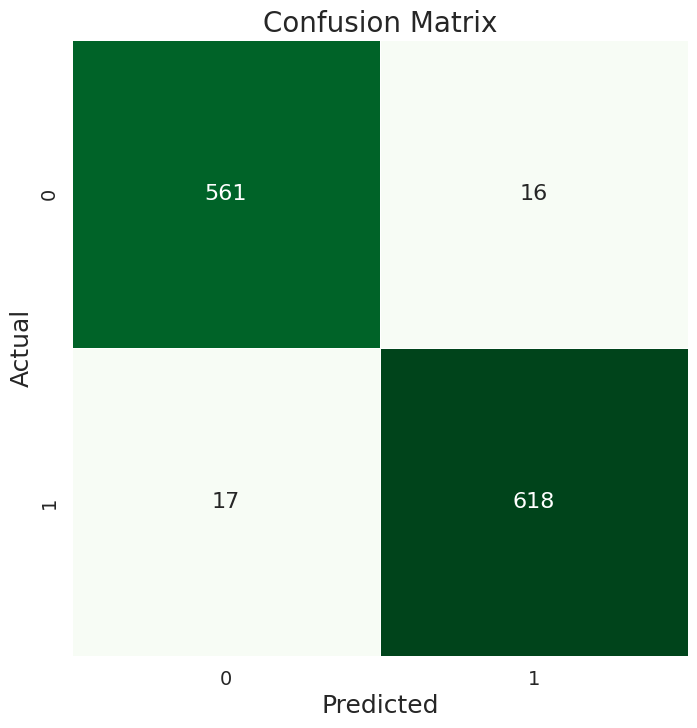

In [ ]:
y = [i.argmax() for i in actual_test_per_step[model_]]
pred = [i.argmax() for i in predictions_test_per_step[model_]]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test, confusion_matrix_name)

# **EXTRA**

In [ ]:
# Hyper Paramaters

#LSTM
univariate = False
n_steps_in = 10
n_seq = 2
n_steps_out = 2
n_features_in = 65
n_features_out = 2
hidden_layers = 50
Epochs = 1000
No_exp = 1
batch_size = 128

print(f"Univariate: {univariate}")
print(f"Number of Input Time Steps: {n_steps_in}")
print(f"Number of Input Sequences: {n_seq}")
print(f"Number of Output Time Steps: {n_steps_out}")
print(f"Number of Input Features: {n_features_in}")
print(f"Number of Output Features: {n_features_out}")
print(f"Number of Hidden Layers: {hidden_layers}")
print(f"Epochs: {Epochs}")
print(f"Number of Experiments: {No_exp}")
print(f"Batch size: {batch_size}")

#Optimiser
lr_adam = 0.0001

#Loss Function
label_smoothing = 0.05

#Activation
negative_slope = 0.01

#Optimizer and Loss Function
optimizer = Adam(learning_rate = lr_adam)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing)
activation_lstm = tf.keras.layers.LeakyReLU(negative_slope = negative_slope)
# activation_lstm = tf.keras.activations.swish
# activation_lstm = 'relu'
activation_dense = 'softmax'

Univariate: False
Number of Input Time Steps: 10
Number of Input Sequences: 2
Number of Output Time Steps: 2
Number of Input Features: 65
Number of Output Features: 2
Number of Hidden Layers: 50
Epochs: 1000
Number of Experiments: 1
Batch size: 128


In [ ]:
#models = ['vanilla', 'bidirectional', 'cnn-lstm', 'conv-lstm']
models = ['bidirectional']
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()
train_loss_all = dict()
test_loss_all = dict()

---------------------------------------------------------
No of steps out: 1
For bidirectional:
(4846, 10, 65) (1212, 10, 65) (4846, 2) (1212, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


Train Acc: 0.9990, Test Acc: 0.9835
Train Recall: 1.0000, Test Recall: 0.9811
Train Precision: 0.9979, Test Precision: 0.9873
Train F1: 0.9990, Test F1: 0.9842
Train ROC AUC: 1.0000, Test ROC AUC: 0.9976

Total Time for 1 Experiments: 15086.08 sec
Mean Test F1: 0.9842, Mean Test ROC AUC: 0.9976


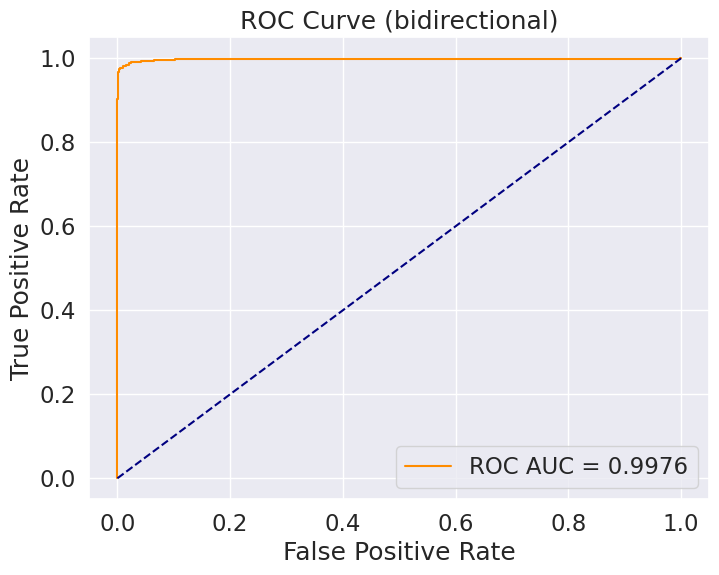

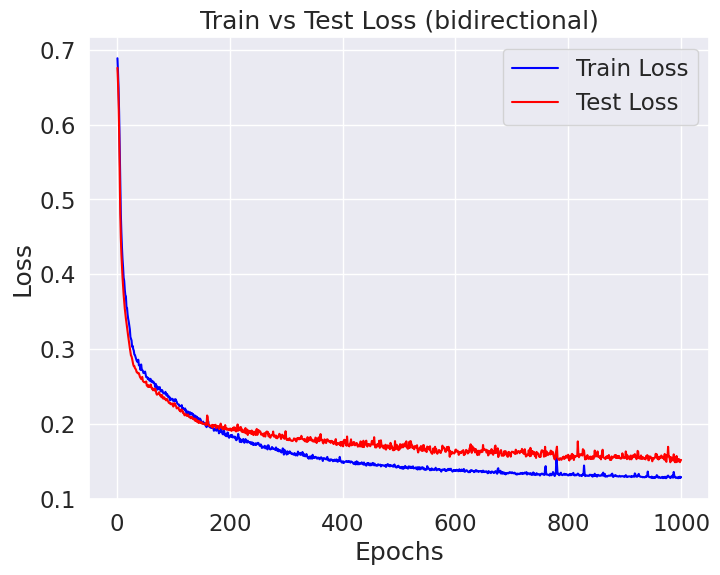

In [ ]:
for j in range(No_exp):
    predictions_train_per_step = dict()
    actual_train_per_step = dict()
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    test_acc_per_step = dict()
    test_stddev_per_step = dict()
    train_loss_per_step = dict()
    test_loss_per_step = dict()

    n_steps_out = j + 1
    print('---------------------------------------------------------')
    print('No of steps out:', n_steps_out)

    for i in models:
        print("For " + i + ":")

        # Reshaping input data based on the model type
        if i in ['vanilla', 'bidirectional']:
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

        elif i == 'cnn-lstm':
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))

        elif i == 'conv-lstm':
            x_train, y_train = np.asarray(train_X), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))

        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

        # Train the model and return loss values
        model, train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test, train_loss, test_loss, roc_auc_train_values, roc_auc_test_values = MODEL_LSTM(
            i, 'original', univariate, x_train, x_test, y_train, y_test, 1, n_steps_in, n_steps_out, Epochs, hidden_layers)


        # Store results
        predictions_train_per_step[i] = y_predicttrain
        actual_train_per_step[i] = y_train
        predictions_test_per_step[i] = Best_Predict_Test
        actual_test_per_step[i] = y_test
        metrics_train_per_step[i] = report_train
        metrics_test_per_step[i] = report_test
        test_acc_per_step[i] = test_acc
        test_stddev_per_step[i] = test_std_dev
        train_loss_per_step[i] = train_loss
        test_loss_per_step[i] = test_loss

    # Save results per step
    predictions_train[str(j+1)] = predictions_train_per_step
    actual_train[str(j+1)] = actual_train_per_step
    predictions_test[str(j+1)] = predictions_test_per_step
    actual_test[str(j+1)] = actual_test_per_step
    metrics_train[str(j+1)] = metrics_train_per_step
    metrics_test[str(j+1)] = metrics_test_per_step
    test_acc_all[str(j+1)] = test_acc_per_step
    test_stddev[str(j+1)] = test_stddev_per_step
    train_loss_all[str(j+1)] = train_loss_per_step
    test_loss_all[str(j+1)] = test_loss_per_step

In [ ]:
def make_confusion_matrix_chart(cf_matrix, name):
    sns.set(style="darkgrid", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens',
                linewidths=.5, square=True, cbar=False,
                annot_kws={"size": 16}, ax=ax)

    plt.ylabel("Actual", size=18)
    plt.xlabel("Predicted", size=18)
    plt.title("Confusion Matrix", size=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()

    return None

In [ ]:
model_ = 'bidirectional'
confusion_matrix_name = 'bidirectional_cm'

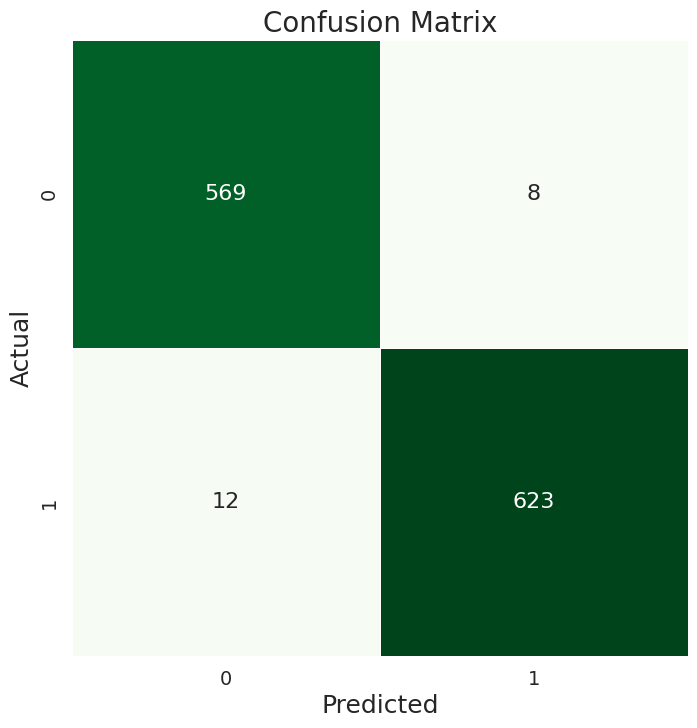

In [ ]:
y = [i.argmax() for i in actual_test_per_step[model_]]
pred = [i.argmax() for i in predictions_test_per_step[model_]]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test, confusion_matrix_name)

# **Testing on Test set by pretrained model**

In [23]:
def preprocess_(folder_path, label, smile, scaler, n=10):
    X, y = [], []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if not file_path.lower().endswith(('.wav', '.mp3', '.flac')):
            continue

        try:
            signal, sampling_rate = audiofile.read(file_path, always_2d=True)
            features = smile.process_signal(signal, sampling_rate).to_numpy()

            segments = [features[i:i+n] for i in range(0, len(features) - n + 1, n)]
            segments = [segment for segment in segments if segment.shape == (n, features.shape[1])]

            if not segments:
                continue

            X.extend(segments)
            y.extend([label] * len(segments))

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

In [33]:
def evaluate_model_(parkinson_path, healthy_path, model_path, scaler_path, scale_option='preloaded', n=10):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    loaded_model = load_model(model_path, custom_objects={'LeakyReLU': activation_lstm})
    loaded_model.summary()

    X_parkinson, y_parkinson = preprocess_(parkinson_path, 1, smile, None, n)
    X_healthy, y_healthy = preprocess_(healthy_path, 0, smile, None, n)

    min_size = min(len(y_parkinson), len(y_healthy))

    indices_parkinson = np.random.choice(len(y_parkinson), min_size, replace=False)
    indices_healthy = np.random.choice(len(y_healthy), min_size, replace=False)

    X_parkinson, y_parkinson = X_parkinson[indices_parkinson], y_parkinson[indices_parkinson]
    X_healthy, y_healthy = X_healthy[indices_healthy], y_healthy[indices_healthy]

    X = np.vstack((X_parkinson, X_healthy))
    y = np.hstack((y_parkinson, y_healthy))
    indices = np.random.permutation(len(y))
    X, y = X[indices], y[indices]

    X_reshaped = X.reshape(-1, X.shape[-1])

    if scale_option == 'preloaded':
        scaler = joblib.load(scaler_path)
    else:
        scaler = MinMaxScaler()   #changed to MinMaxScalar
        scaler.fit(X_reshaped)

    X_scaled = scaler.transform(X_reshaped)
    X_normalized = X_scaled.reshape(X.shape)

    # ----- cnn-lstm
    # X_normalized = np.asarray(X_normalized)
    # X_normalized = X_normalized.reshape((X_normalized.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))

    #----- conv-lstm
    # X_normalized = np.asarray(X_normalized)
    # X_normalized = X_normalized.reshape((X_normalized.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))

    predictions = loaded_model.predict(X_normalized)
    y_pred = np.array([pred.argmax() for pred in predictions])

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"Model Evaluation Metrics:\n---------------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {roc_auc:.4f}\n")

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          23,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,304 (91.04 KB)

 Trainable params: 23,302 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Model Evaluation Metrics:
---------------------------
Accuracy: 0.4885
F1 Score: 0.6434
AUC Score: 0.5125



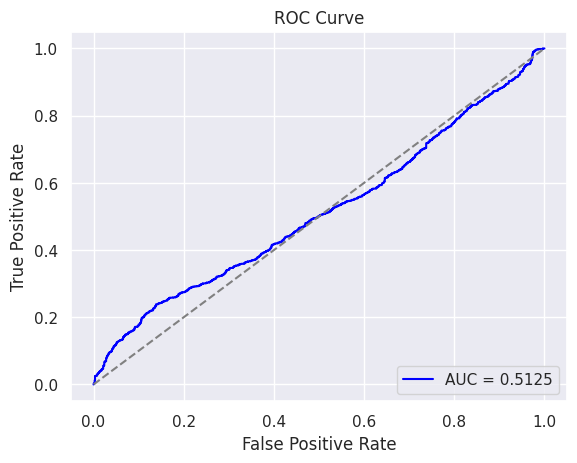

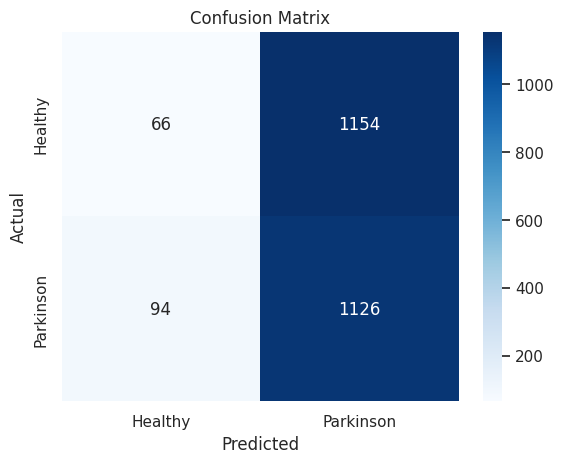

In [34]:
pd_path = "/content/Telephone_a_PD"
hs_path = "/content/Telephone_a_HS"
model_path = "/content/Italian_a_models/model_vanilla_italian_a.h5"
scaler_path = "/content/scalars/scaler_italian_a.pkl"
# scale_option = 'preloaded'
scale_option = None
evaluate_model_(pd_path, hs_path, model_path, scaler_path, scale_option, n=10)

# **Check for a particular audio**

In [ ]:
def classify_parkinson_folder(folder_path, model_path, scaler_path, n=10):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    # Load the trained scaler and model
    scaler = joblib.load(scaler_path)
    loaded_model = load_model(model_path, custom_objects={'LeakyReLU': activation_lstm})

    results = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if not file_path.lower().endswith(('.wav', '.mp3', '.flac')):
            continue  # Skip non-audio files

        try:
            signal, sampling_rate = audiofile.read(file_path, always_2d=True)
            features = smile.process_signal(signal, sampling_rate).to_numpy()
            segments = [features[i:i+n] for i in range(0, len(features) - n + 1, n)]
            segments = [segment for segment in segments if segment.shape == (n, features.shape[1])]

            if not segments:
                continue

            X = np.array(segments, dtype=np.float32)
            X_reshaped = X.reshape(-1, X.shape[-1])
            X_scaled = scaler.transform(X_reshaped)
            X_normalized = X_scaled.reshape(X.shape)

            # ----- cnn-lstm
            # X_normalized = np.asarray(X_normalized)
            # X_normalized = X_normalized.reshape((X_normalized.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))

            #----- conv-lstm
            # X_normalized = np.asarray(X_normalized)
            # X_normalized = X_normalized.reshape((X_normalized.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))



            predictions = loaded_model.predict(X_normalized)
            predicted_classes = np.array([pred.argmax() for pred in predictions])

            num_parkinson = np.sum(predicted_classes == 1)
            num_not_parkinson = np.sum(predicted_classes == 0)
            dominant_class = "Parkinson" if num_parkinson > num_not_parkinson else "Not Parkinson"

            results.append({
                'File Name': file_name,
                'Num Parkinson': num_parkinson,
                'Num Not Parkinson': num_not_parkinson,
                'Dominant Class': dominant_class
            })

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    return pd.DataFrame(results)

In [ ]:
folder_path = "/content/Test/HS"
model_path = "/content/model_conv-lstm_original.h5"
scaler_path = "/content/scaler.pkl"
df = classify_parkinson_folder(folder_path, model_path, scaler_path, n=10)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


In [ ]:
df

,File Name,Num Parkinson,Num Not Parkinson,Dominant Class
0,VA1MGIACTHT49M210320170855.wav,0,29,Not Parkinson
1,VA1LSUUIMGM48F230320171053.wav,2,27,Not Parkinson
2,AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2.wav,18,10,Parkinson
3,AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6.wav,0,22,Not Parkinson
4,AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav,35,1,Parkinson
5,VA1LPUUITGI41M230320171111.wav,3,26,Not Parkinson


In [ ]:
# def classify_parkinson(file_path, model_path, scaler_path,  n=10):
#     smile = opensmile.Smile(
#         feature_set=opensmile.FeatureSet.ComParE_2016,
#         feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
#     )

#     signal, sampling_rate = audiofile.read(file_path, always_2d=True)
#     features = smile.process_signal(signal, sampling_rate).to_numpy()
#     segments = [features[i:i+n] for i in range(0, len(features) - n + 1, n)]
#     segments = [segment for segment in segments if segment.shape == (n, features.shape[1])]

#     if not segments:
#         print("No valid segments found.")
#         return

#     X = np.array(segments, dtype=np.float32)
#     print(X.shape)
#     # scaler = MinMaxScaler()
#     scaler = joblib.load(scaler_path)  # Load the trained scaler
#     X_reshaped = X.reshape(-1, X.shape[-1])  # Flatten for scaling
#     X_scaled = scaler.transform(X_reshaped)  # Apply MinMax scaling
#     X_normalized = X_scaled.reshape(X.shape)  # Reshape back to original form
#     # print(X_normalized)

#     loaded_model = load_model(model_path)
#     predictions = loaded_model.predict(X_normalized)
#     # predictions = model.predict(X_normalized)
#     # print(predictions)
#     predicted_classes = [predictions[i].argmax() for i in range(predictions.shape[0])]
#     predicted_classes = np.array(predicted_classes)
#     # print(predicted_classes)
#     num_parkinson = np.sum(predicted_classes == 1)
#     num_not_parkinson = np.sum(predicted_classes == 0)
#     dominant_class = "Parkinson" if num_parkinson > num_not_parkinson else "Not Parkinson"

#     print(f"Number of Parkinson cases: {num_parkinson}")
#     print(f"Number of Not Parkinson cases: {num_not_parkinson}")
#     print(f"Patient is classified as: {dominant_class}")

#     # return dominant_class, num_parkinson, num_not_parkinson
#     return None

In [ ]:
# file_path = "/content/Test/HS/VA2TMEIRAEC54F230320171153.wav"
# model_path = "/content/model_vanilla_original.h5"
# scaler_path = "/content/scaler.pkl"
# classify_parkinson(file_path, model_path, scaler_path, n=10)

(29, 10, 65)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Number of Parkinson cases: 24
Number of Not Parkinson cases: 5
Patient is classified as: Parkinson
